# Simulated EAP pre-processing

In [1]:
import os
import sys
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.interpolate import CubicSpline, interp1d
import colorednoise as cn

In [2]:
pd.__version__

'1.3.1'

In [3]:
resample = 82 # number or False
global_noise = False
spacing = 10

In [4]:
pyr_labels =  ['L5_TTPC1_%s'%(i+1) for i in range(5)]+ \
                    ['L5_TTPC2_%s'%(i+1) for i in range(5)]+   \
                    ['L5_UTPC_%s'%(i+1) for i in range(5)]+  \
                    ['L5_STPC_%s'%(i+1) for i in range(5)]+  \
                    ['L6_TPC_L4_%s'%(i+1) for i in range(5)]+\
                    ['L6_TPC_L1_%s'%(i+1) for i in range(5)]+\
                    ['L6_IPC_%s'%(i+1) for i in range(5)]+ \
                    ['L6_UTPC_%s'%(i+1) for i in range(5)]+ \
                    ['L6_BPC_%s'%(i+1) for i in range(5)]+ \
                    ['L4_SS_%s'%(i+1) for i in range(5)]+ \
                    ['L4_SP_%s'%(i+1) for i in range(5)]+\
                    ['L23_PC_%s'%(i+1) for i in range(5)]
    
int_labels =  ['L23_NBC_%s'%(i+1) for i in range(5)]+ \
                ['L23_MC_%s'%(i+1) for i in range(5)]+ \
                ['L23_BTC_%s'%(i+1) for i in range(5)]+ \
                ['L23_DBC_%s'%(i+1) for i in range(5)]+ \
                ['L23_BP_%s'%(i+1) for i in range(5)]+ \
                ['L23_LBC_%s'%(i+1) for i in range(5)]+ \
                ['L23_SBC_%s'%(i+1) for i in range(5)]+ \
                ['L23_ChC_%s'%(i+1) for i in range(5)]+ \
                ['L23_NGC_%s'%(i+1) for i in range(5)]

cell_labels = pyr_labels + int_labels # 0, 57, 87

In [335]:
# cellLabel = cell_labels[87]
# cellLabel = 'L6_TPC_L1_4'
cellLabel = 'L5_UTPC_4'
cellLabel

'L5_UTPC_4'

In [336]:
data_df = pd.read_pickle('adjusted_uniform_set/%s_opt_simulated_eaps.pkl'%cellLabel)

In [337]:
data_df.head()

,Model_ID,t,vm,ve,x_bar,y_bar,z_bar,num_spikes,did_spike,first_spkt
0,NMLCL000700,"[1000.008000000037, 1000.032000000037, 1000.05...","[-57.01839667055374, -56.683965332891205, -56....","[5.004757330466928e-05, 5.144940269429514e-05,...",-27.831558,-253.820301,1.746427,14,True,26.224
1,NMLCL000700,"[1000.008000000037, 1000.032000000037, 1000.05...","[-57.01839667055374, -56.683965332891205, -56....","[9.095946954793604e-05, 9.246406937566076e-05,...",-27.831558,-243.820301,1.746427,14,True,26.224
2,NMLCL000700,"[1000.008000000037, 1000.032000000037, 1000.05...","[-57.01839667055374, -56.683965332891205, -56....","[0.00011270553518162685, 0.0001143512669002226...",-27.831558,-233.820301,1.746427,14,True,26.224
3,NMLCL000700,"[1000.008000000037, 1000.032000000037, 1000.05...","[-57.01839667055374, -56.683965332891205, -56....","[0.00013005435186203807, 0.0001318715001805184...",-27.831558,-223.820301,1.746427,14,True,26.224
4,NMLCL000700,"[1000.008000000037, 1000.032000000037, 1000.05...","[-57.01839667055374, -56.683965332891205, -56....","[0.00014724831831386376, 0.0001492697512686108...",-27.831558,-213.820301,1.746427,14,True,26.224


In [338]:
num_channels = len(data_df)//100
num_channels

50

In [339]:
from scipy.signal import find_peaks

Where is spike: 58
potential problems: []


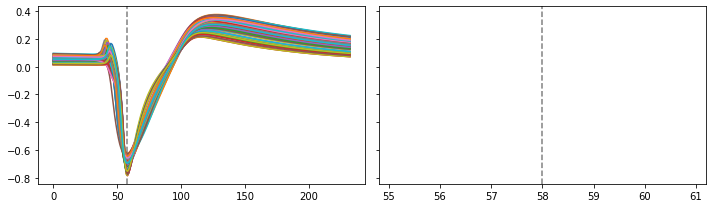

In [340]:
fig, axs = plt.subplots(1,2,figsize=(10,3),sharey=True)

offset_units = []
look_at_these = []

for unit in range(100):
    unit_df = data_df.iloc[num_channels*unit:num_channels*(unit+1)].copy()
    unit_df['channel_num'] = [chan for chan in np.arange(num_channels)]

    
    vm = unit_df.vm.iloc[0] 
    t =  unit_df.t.iloc[0]
    pre_spk_dur = 1.4
    duration = 5.6

    lb = pre_spk_dur
    ub = duration-pre_spk_dur

    # have to ignore spikes near the boundaries of the timeseries
    # NOTE: This will flag an error if none exist 
    # -- since vm_spk and vm_spk_i will be undefined
    all_peaks = find_peaks(vm)[0]
    all_peak_times = t[all_peaks]
    for i, peak in enumerate(all_peak_times):
        if ((peak-lb)>=t[0]) and ((peak+ub)<=t[-1]):
            peak_time = peak
            peak_shift_i = all_peaks[i]
            break

    
    buff = 2
    start_time = peak_time-buff # added buffer
    end_time = peak_time+2*buff # added buffer

    # approximate reduced timeseries condition
    t_cond = (t>=start_time)&(t<end_time)

    # find actual maximum channel
    temp_amps = []
    try:
        for _, row_df in unit_df.iterrows():
            wave = row_df['ve']
            wave = wave[t_cond]
            
            amp = np.max(wave)-np.min(wave)

            temp_amps.append(amp)
    except ValueError:
        raise Exception('ValueError: Length of Probe= %s | Peak time= %.2f'%(len(unit_df),peak_time))


    # actual times for aligning waveforms
    temp_amps = np.array(temp_amps)
    max_channel_i = np.argmax(temp_amps) # max channel without

    max_chan_ve = unit_df[unit_df['channel_num']==max_channel_i]['ve'].iloc[0]

    # get new extracellular spike time
    peak_time_0 = peak_time
    
    # some spikes are inverted, find out which is the case for peak
#     if np.abs(np.min(max_chan_ve[t_cond]))>np.max(max_chan_ve[t_cond]):
#         peak = np.argmin(max_chan_ve[t_cond])
#     else:
#         peak = np.argmax(max_chan_ve[t_cond])
        
        
    min_peak = np.argmin(max_chan_ve[t_cond])
    min_peak_time = t[min_peak+peak_shift_i-int((buff/dt))]
    
    max_peak = np.argmax(max_chan_ve[t_cond])
    max_peak_time = t[max_peak+peak_shift_i-int((buff/dt))]
    
    min_diff = np.abs(peak_time_0-min_peak_time)
    max_diff = np.abs(peak_time_0-max_peak_time)
    
    
    # take whichever is more accurate
    if min_diff<max_diff:
        peak_time = min_peak_time
        peak = min_peak
        
    else:
        peak_time = max_peak_time
        peak = max_peak
    
#     # some spikes are inverted, and min will not be close
#     # use which ever is closer to the true spike time - min or max
#     if diff>1:
#         print('Peak time difference: %s'%diff)
#         peak = np.argmax(max_chan_ve[t_cond])
#         peak_time = t[peak+peak_shift_i-int((buff/dt))]
        
#         offset_units.append(unit)
        
    
#     peak_time = t[peak+peak_shift_i-int((buff/dt))]
#     diff = np.abs(peak_time_0-peak_time)
#     if diff>1: # if greater than a millisecond
#         print('Peak time difference: %s'%diff)
#         offset_units.append(unit)
        
#         # sometimes the peak-to-trough ratio is larger but the spike is not inverted, etc
#         if peak == np.argmin(max_chan_ve[t_cond]):
#             peak = np.argmax(max_chan_ve[t_cond]) # so use max instead
#         else:
#             peak = np.argmin(max_chan_ve[t_cond]) # so use min instead
#         peak_time = t[peak+peak_shift_i-int((buff/dt))]
        
        
        
    new_t_cond = (t>=peak_time-pre_spk_dur)&(t<peak_time-pre_spk_dur+duration)
    
    this_peak_idx = np.argwhere(t[new_t_cond]>=peak_time)[0][0]
    this_ve = max_chan_ve[new_t_cond]
    this_ve = this_ve/np.max(temp_amps)
    if this_ve[this_peak_idx]<0:
        axs[0].plot(this_ve)
    else:
        axs[1].plot(this_ve)
        
    if this_ve[20]<-0.25:
        look_at_these.append(unit)
        
        
        
print('Where is spike:',this_peak_idx)
for i in range(2):
    axs[i].axvline(this_peak_idx,color='gray',linestyle='--',zorder=0)

# print('offset:',offset_units)
print('potential problems:',look_at_these)
plt.tight_layout();

[1002.168 1019.52 ]


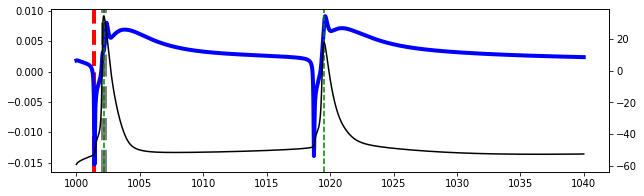

In [320]:
#### USE TO LOOK AT PROBLEM CHILDREN
unit = 75
test_df = data_df.iloc[num_channels*unit:num_channels*(unit+1)].copy()
test_df['channel_num'] = [chan for chan in np.arange(num_channels)]

t = test_df.t.iloc[0]
vm = test_df.vm.iloc[0]
ve = test_df.ve.iloc[25]

pre_spk_dur = 1.4
duration = 5.6

lb = pre_spk_dur
ub = duration-pre_spk_dur


# have to ignore spikes near the boundaries of the timeseries
# NOTE: This will flag an error if none exist 
# -- since vm_spk and vm_spk_i will be undefined
all_peaks = find_peaks(vm)[0]
all_peak_times = t[all_peaks]
print(all_peak_times)
for i, peak_time in enumerate(all_peak_times):
    if ((peak_time-lb)>=t[0]) and ((peak_time+ub)<=t[-1]):
        vm_spk = peak_time
        vm_spk_i = all_peaks[i]
        break


dt = t[1]-t[0]

# find the right spike time
buff = 2
t_cond = (t>=(vm_spk-buff))&(t<=(vm_spk+buff))


# find actual maximum channel
temp_amps = []
try:
    for _, row_df in test_df.iterrows():
        wave = row_df['ve']
        wave = wave[t_cond]

        amp = np.max(wave)-np.min(wave)

        temp_amps.append(amp)
except ValueError:
    raise Exception('ValueError: Length of Probe= %s | Peak time= %.2f'%(len(test_df),vm_spk))


# actual times for aligning waveforms
temp_amps = np.array(temp_amps)
max_channel_i = np.argmax(temp_amps) # max channel without

max_chan_ve = test_df[test_df['channel_num']==max_channel_i]['ve'].iloc[0]

ve_spk = t[np.argmin(max_chan_ve[t_cond])+vm_spk_i-int((buff/dt))]



fig, ax = plt.subplots(1,1,figsize=(10,3))
ax.plot(t,max_chan_ve,color='b',linewidth=4)
ax.axvline(vm_spk,color='gray',linestyle='--',linewidth=6,zorder=0)
ax.axvline(ve_spk,color='r',linestyle='--',linewidth=4,zorder=0)

for peak in find_peaks(vm)[0]:
    ax.axvline(t[peak],color='g',linestyle='--')

ax2 = ax.twinx()
ax2.plot(t,vm,color='k')

# ax.set_xlim(t[0],t[int(0.5*len(t))]);

In [9]:
probes = pickle.load( open("adjusted_uniform_set/%s_opt_recording_probes.pkl"%cellLabel, "rb" ) )
probes = np.array(probes)

In [10]:
num_probes, num_channels, _ = np.shape(probes)


In [11]:
probe_nums = []
channel_nums = []

for i, row_df in data_df.iterrows():
    probe_nums.append(int(i/num_channels))
    channel_nums.append(i%num_channels)
    
    

In [12]:
data_df['probe_num'] = probe_nums
data_df['channel_num'] = channel_nums



In [13]:
def find_closest_probe(probes,max_channel_i = 25):
    
    num_probes, _, _ = np.shape(probes)
    distances = []
    
    for i in range(num_probes):
        probe = probes[i,:,:]
        x,y,z = probe[max_channel_i]
        dist = np.sqrt(x**2+y**2+z**2)
        distances.append(dist)
        
    print('Closest probe found at %s microns...'%np.min(distances))
    return np.argmin(distances)

def find_farthest_probe(probes,max_channel_i = 25):
    
    num_probes, _, _ = np.shape(probes)
    distances = []
    
    for i in range(num_probes):
        probe = probes[i,:,:]
        x,y,z = probe[max_channel_i]
        dist = np.sqrt(x**2+y**2+z**2)
        distances.append(dist)
        
    print('Farthest probe found at %s microns...'%np.max(distances))
    return np.argmax(distances)

In [45]:
closest_probe = find_closest_probe(probes,max_channel_i=32)
farthest_probe = find_farthest_probe(probes,max_channel_i=32)



Closest probe found at 11.21678161995888 microns...
Farthest probe found at 49.959080485413494 microns...


In [34]:
closest_probe

63

In [16]:
this_probe = np.random.choice(num_probes)

In [17]:
# probes[this_probe,:,:]
probes[closest_probe,:,:]

array([[   9.60149132, -315.53083314,   -5.59465753],
       [   9.60149132, -305.53083314,   -5.59465753],
       [   9.60149132, -295.53083314,   -5.59465753],
       [   9.60149132, -285.53083314,   -5.59465753],
       [   9.60149132, -275.53083314,   -5.59465753],
       [   9.60149132, -265.53083314,   -5.59465753],
       [   9.60149132, -255.53083314,   -5.59465753],
       [   9.60149132, -245.53083314,   -5.59465753],
       [   9.60149132, -235.53083314,   -5.59465753],
       [   9.60149132, -225.53083314,   -5.59465753],
       [   9.60149132, -215.53083314,   -5.59465753],
       [   9.60149132, -205.53083314,   -5.59465753],
       [   9.60149132, -195.53083314,   -5.59465753],
       [   9.60149132, -185.53083314,   -5.59465753],
       [   9.60149132, -175.53083314,   -5.59465753],
       [   9.60149132, -165.53083314,   -5.59465753],
       [   9.60149132, -155.53083314,   -5.59465753],
       [   9.60149132, -145.53083314,   -5.59465753],
       [   9.60149132, -135.

In [35]:
# probe_df = data_df[data_df.probe_num==this_probe]
probe_df = data_df[data_df.probe_num==closest_probe]
# probe_df = data_df[data_df.probe_num==0]



(1001.5, 1030.0)

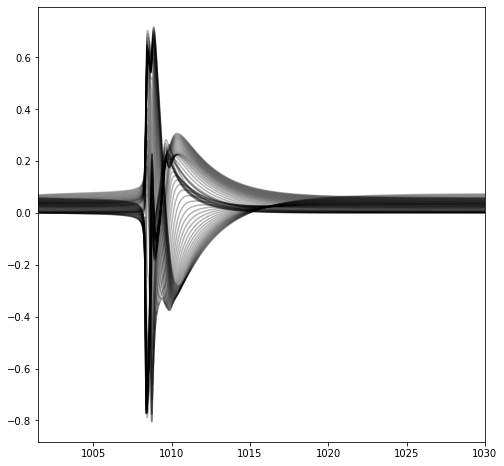

In [36]:
plt.figure(figsize=(8,8))
for _, row_df in probe_df.iterrows():
    
    t = row_df['t']
    ve = row_df['ve']
    amp = np.max(ve)-np.min(ve)

    norm_ve = np.divide(ve,amp)
    
    plt.plot(t,norm_ve,'k',alpha=0.3)
    chan_num = row_df['channel_num']

plt.xlim(1001.5,1030)



(1001.5, 1030.0)

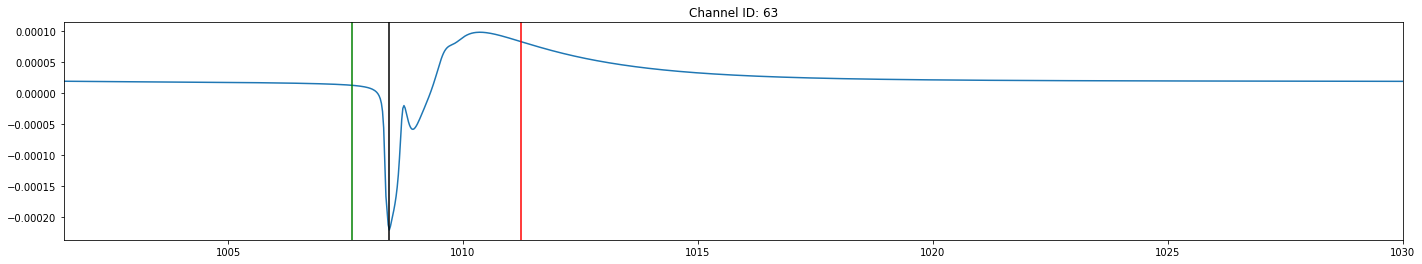

In [37]:
plt.figure(figsize=(24,4))
plt.plot(t,ve)

peak_time = t[np.argmin(ve)]

start_time = peak_time-0.8
end_time = start_time+3.6

plt.axvline(peak_time,color='k')
plt.axvline(start_time,color='g')
plt.axvline(end_time,color='r')

plt.title('Channel ID: %s'%chan_num)
plt.xlim(1001.5,1030)

## Maximum channel peak to align waveforms

- Total duration: 3.6 ms
- Time of peak: 0.8 ms


In [38]:
probe_df.columns.tolist()

['Model_ID',
 't',
 'vm',
 've',
 'x_bar',
 'y_bar',
 'z_bar',
 'num_spikes',
 'did_spike',
 'first_spkt',
 'probe_num',
 'channel_num']

32


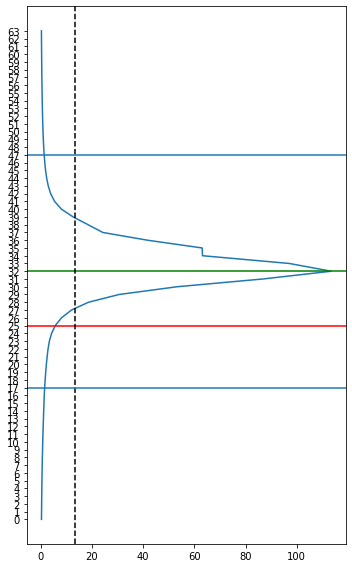

In [39]:
probe_df = data_df[data_df.probe_num==closest_probe]
# probe_df = data_df[data_df.probe_num==0]


amps = []

for i, (_,row_df) in enumerate(probe_df.iterrows()):
    
    amps.append(np.max(row_df.ve)-np.min(row_df.ve))

plt.figure(figsize=(5,8))
plt.plot(1e3*np.array(amps),np.arange(len(probe_df)))

true_max = np.argmax(amps)
test_max = 25
plt.axhline(true_max,color='g')
plt.axhline(test_max,color='r')

plt.axvline(0.12*1e3*np.max(amps),color='k',linestyle='--')
plt.yticks(np.arange(len(probe_df)))

plt.axhline(true_max+15)
plt.axhline(true_max-15)

plt.tight_layout()

print(true_max)



32


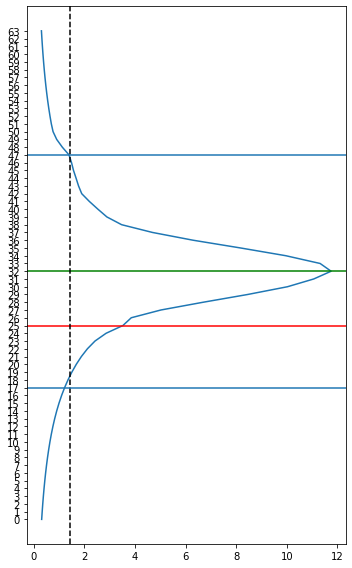

In [42]:
probe_df = data_df[data_df.probe_num==farthest_probe]


amps = []

for i, (_,row_df) in enumerate(probe_df.iterrows()):
    
    amps.append(np.max(row_df.ve)-np.min(row_df.ve))

plt.figure(figsize=(5,8))
plt.plot(1e3*np.array(amps),np.arange(len(probe_df)))

true_max = np.argmax(amps)
test_max = 25
plt.axhline(true_max,color='g')
plt.axhline(test_max,color='r')

plt.axvline(0.12*1e3*np.max(amps),color='k',linestyle='--')
plt.yticks(np.arange(len(probe_df)))

plt.axhline(true_max+15)
plt.axhline(true_max-15)

plt.tight_layout()

print(true_max)



Distance: 87.56525245533028
32


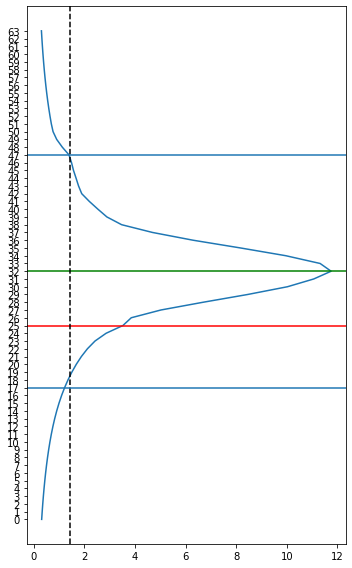

In [46]:
rand_probe = np.random.choice(num_probes)

probe_df = data_df[data_df.probe_num==rand_probe]

x = probe_df.x_bar.iloc[25]
y = probe_df.y_bar.iloc[25]
z = probe_df.z_bar.iloc[25]
dist = np.sqrt(x**2+y**2+z**2)
print('Distance:',dist)

amps = []

for i, (_,row_df) in enumerate(probe_df.iterrows()):
    
    amps.append(np.max(row_df.ve)-np.min(row_df.ve))

plt.figure(figsize=(5,8))
plt.plot(1e3*np.array(amps),np.arange(len(probe_df)))

true_max = np.argmax(amps)
test_max = 25
plt.axhline(true_max,color='g')
plt.axhline(test_max,color='r')

plt.axvline(0.12*1e3*np.max(amps),color='k',linestyle='--')
plt.yticks(np.arange(len(probe_df)))

plt.axhline(true_max+15)
plt.axhline(true_max-15)

plt.tight_layout()

print(true_max)



In [47]:
max_channel_i = 32

In [72]:
x = probes[closest_probe,max_channel_i,0]
y = probes[closest_probe,max_channel_i,1]
z = probes[closest_probe,max_channel_i,2]

distance = np.sqrt(np.square(x)+np.square(y)+np.square(z))
print('probe distance:',distance,'microns')


probe distance: 11.21678161995888 microns


In [73]:
probe_df.head()

,Model_ID,t,vm,ve,x_bar,y_bar,z_bar,num_spikes,did_spike,first_spkt,probe_num,channel_num
2560,NMLCL000482,"[1000.008000000037, 1000.032000000037, 1000.05...","[-62.32126549805659, -62.26379333623696, -62.2...","[1.9904860934731656e-05, 1.9943695676475474e-0...",-30.777575,-321.941169,39.304993,2,True,1008.712,40,0
2561,NMLCL000482,"[1000.008000000037, 1000.032000000037, 1000.05...","[-62.32126549805659, -62.26379333623696, -62.2...","[2.0544657434725243e-05, 2.0586407955332983e-0...",-30.777575,-311.941169,39.304993,2,True,1008.712,40,1
2562,NMLCL000482,"[1000.008000000037, 1000.032000000037, 1000.05...","[-62.32126549805659, -62.26379333623696, -62.2...","[2.122757181883323e-05, 2.127253013636206e-05,...",-30.777575,-301.941169,39.304993,2,True,1008.712,40,2
2563,NMLCL000482,"[1000.008000000037, 1000.032000000037, 1000.05...","[-62.32126549805659, -62.26379333623696, -62.2...","[2.1957975273899217e-05, 2.2006466405766966e-0...",-30.777575,-291.941169,39.304993,2,True,1008.712,40,3
2564,NMLCL000482,"[1000.008000000037, 1000.032000000037, 1000.05...","[-62.32126549805659, -62.26379333623696, -62.2...","[2.2740864965613226e-05, 2.279324993231765e-05...",-30.777575,-281.941169,39.304993,2,True,1008.712,40,4


In [284]:
t = probe_df.t.iloc[0]
dt = t[1]-t[0]
Fs = 1000./dt

spike_duration = 5.6

print('resolution (ms):',dt,', Fs (Hz):',Fs)


resolution (ms): 0.02400000000000091 , Fs (Hz): 41666.666666665085


In [285]:
# check if probe is aligned properly
max_chan_ve = probe_df[probe_df['channel_num']==max_channel_i]['ve'].iloc[0]
print(len(max_chan_ve))

low_chan_ve = probe_df[probe_df['channel_num']==max_channel_i+15]['ve'].iloc[0]



1667


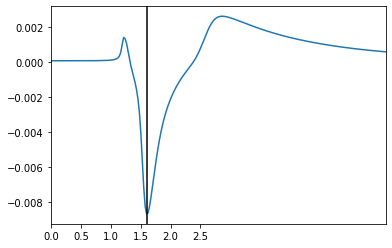

In [286]:
plt.plot(t,max_chan_ve)

peak_time = t[np.argmin(max_chan_ve)]

start_time = peak_time-1.6
end_time = start_time+spike_duration

plt.axvline(peak_time,color='k')
# plt.axvline(start_time,color='g')
# plt.axvline(end_time,color='r')

plt.xlim([start_time,end_time])
ticks = [0.0,0.5,1.0,1.5,2.0,2.5]
xticks = [start_time+i for i in ticks]
plt.xticks(xticks,ticks);



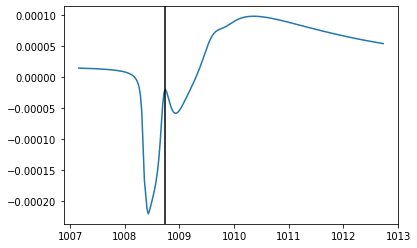

In [287]:
t_cond = (t>=start_time)&(t<end_time)
reduced_t = t[t_cond]
reduced_ve = ve[t_cond]

plt.plot(reduced_t,reduced_ve)
plt.axvline(peak_time,color='k')

## Signal interpolation

In [288]:
conversion_factor = 1e3

In [289]:
t_cond = (t>=start_time)&(t<end_time)
reduced_t = t[t_cond]
reduced_max_ve = conversion_factor*max_chan_ve[t_cond]
reduced_low_ve = conversion_factor*low_chan_ve[t_cond]

T = len(reduced_t)

In [290]:
num_pts = 128
duration = reduced_t[-1]-reduced_t[0]
duration/num_pts

0.04350000000000165

In [291]:
interp_t = np.linspace(0,duration,T)

In [292]:
interp_t

array([0.   , 0.024, 0.048, 0.072, 0.096, 0.12 , 0.144, 0.168, 0.192,
       0.216, 0.24 , 0.264, 0.288, 0.312, 0.336, 0.36 , 0.384, 0.408,
       0.432, 0.456, 0.48 , 0.504, 0.528, 0.552, 0.576, 0.6  , 0.624,
       0.648, 0.672, 0.696, 0.72 , 0.744, 0.768, 0.792, 0.816, 0.84 ,
       0.864, 0.888, 0.912, 0.936, 0.96 , 0.984, 1.008, 1.032, 1.056,
       1.08 , 1.104, 1.128, 1.152, 1.176, 1.2  , 1.224, 1.248, 1.272,
       1.296, 1.32 , 1.344, 1.368, 1.392, 1.416, 1.44 , 1.464, 1.488,
       1.512, 1.536, 1.56 , 1.584, 1.608, 1.632, 1.656, 1.68 , 1.704,
       1.728, 1.752, 1.776, 1.8  , 1.824, 1.848, 1.872, 1.896, 1.92 ,
       1.944, 1.968, 1.992, 2.016, 2.04 , 2.064, 2.088, 2.112, 2.136,
       2.16 , 2.184, 2.208, 2.232, 2.256, 2.28 , 2.304, 2.328, 2.352,
       2.376, 2.4  , 2.424, 2.448, 2.472, 2.496, 2.52 , 2.544, 2.568,
       2.592, 2.616, 2.64 , 2.664, 2.688, 2.712, 2.736, 2.76 , 2.784,
       2.808, 2.832, 2.856, 2.88 , 2.904, 2.928, 2.952, 2.976, 3.   ,
       3.024, 3.048,

In [293]:
cs = CubicSpline(interp_t,reduced_max_ve,axis=0)
new_time = np.linspace(0,duration,num_pts)
new_max_ve = cs(new_time)

In [294]:
cs = CubicSpline(interp_t,reduced_low_ve,axis=0)
new_time = np.linspace(0,duration,num_pts)
new_low_ve = cs(new_time)

In [295]:
len(new_max_ve), len(new_low_ve)

(128, 128)

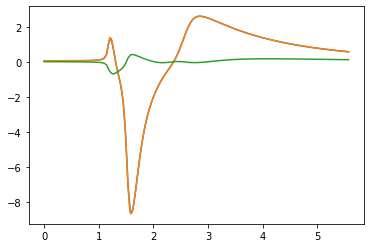

In [296]:
plt.plot(new_time,new_max_ve)
plt.plot(interp_t,reduced_max_ve)
plt.plot(new_time,new_low_ve)

## Noise inclusion

In [129]:
from scipy.stats import laplace

In [464]:
scaling_factor = 10 # 15, 25
noise_generator = cn.powerlaw_psd_gaussian
p1 = 1
num_noisy_spikes = 500
p2 = (num_noisy_spikes,len(new_time))

args = [p1,p2]


noise_signals = scaling_factor*noise_generator(*args)
mean_noise = np.mean(noise_signals,axis=0)

In [465]:
np.shape(noise_signals), np.shape(mean_noise)

((500, 128), (128,))

2.0342531781148985


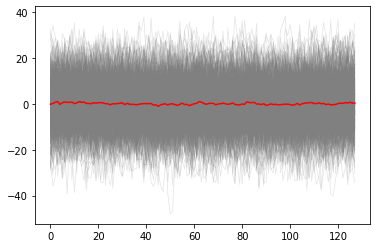

In [466]:
plt.figure()
plt.plot(np.transpose(noise_signals),color='gray',alpha=0.2,linewidth=0.75)

print(np.max(mean_noise)-np.min(mean_noise))
plt.plot(mean_noise,color='r');

52.99897964349171


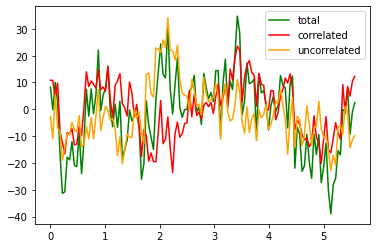

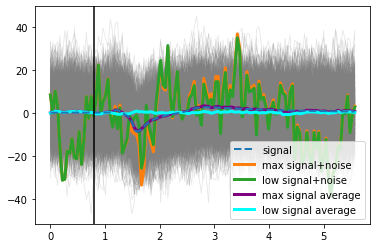

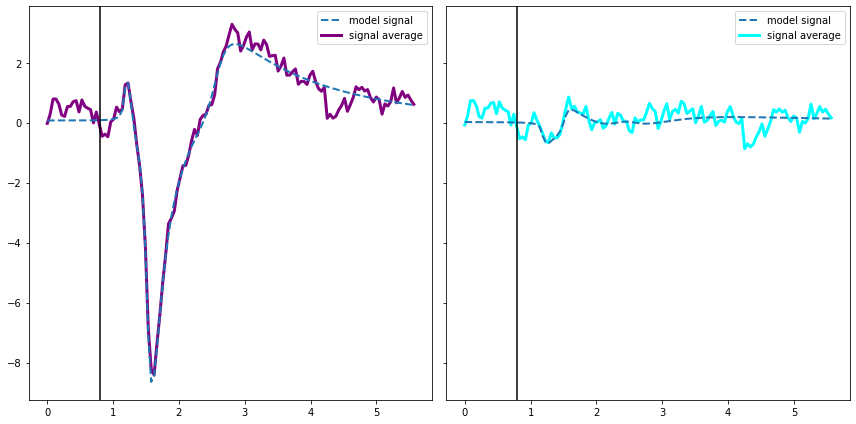

In [326]:
# corr_noise_signal = laplace.rvs(loc,scale,size=len(new_time))
# uncorr_noise_signal = laplace.rvs(loc,scale,size=len(new_time))


scaling_factor = 10 # 15, 25
noise_generator = cn.powerlaw_psd_gaussian
p1 = 1
p2 = len(new_time)
args = [p1,p2]

# scaling_factor = 10 # 15, 25
# noise_generator = laplace.rvs
# p1 = 0
# p2 = 0.5
# p3 = len(new_time)
# args = [p1,p2,p3]

corr_noise_signal = scaling_factor*noise_generator(*args)
uncorr_noise_signal = scaling_factor*noise_generator(*args)
noise_signal = corr_noise_signal + uncorr_noise_signal


plt.figure()
plt.plot(new_time,noise_signal,'g',label='total')
plt.plot(new_time,corr_noise_signal,'r',label='correlated')
plt.plot(new_time,uncorr_noise_signal,'orange',label='uncorrelated')
plt.legend()

synth_max_ve = np.add(new_max_ve,noise_signal)
synth_low_ve = np.add(new_low_ve,noise_signal)

plt.figure()

# Spike-triggered average
# create 100 spikes recorded at the same distance and check average
synth_max_signals = []
synth_low_signals = []
noise_signals = []
for i in range(1000):
    

    noise_signal = scaling_factor*noise_generator(*args)
    
#     pseudo_time = np.linspace(0,duration,len(noise_signal))
#     cs = CubicSpline(pseudo_time,noise_signal,axis=0)
#     new_time = np.linspace(0,duration,num_pts)
#     noise_signal = cs(new_time)
    
    noise_signals.append(noise_signal)
    
    max_signal = np.add(new_max_ve,noise_signal)
    synth_max_signals.append(list(max_signal))
    
    low_signal = np.add(new_low_ve,noise_signal)
    synth_low_signals.append(list(low_signal))
    
    plt.plot(new_time,max_signal,alpha=0.2,linewidth=0.75,color='gray',zorder=0)

mean_max_signal = np.mean(np.array(synth_max_signals),axis=0)
mean_low_signal = np.mean(np.array(synth_low_signals),axis=0)


plt.plot(new_time,new_max_ve,linestyle='--',linewidth=2,label='signal')
plt.plot(new_time,synth_max_ve,linewidth=3,label='max signal+noise',zorder=0)
plt.plot(new_time,synth_low_ve,linewidth=3,label='low signal+noise',zorder=0)

plt.plot(new_time,mean_max_signal,color='purple',linewidth=3,label='max signal average',zorder=0)
plt.plot(new_time,mean_low_signal,color='cyan',linewidth=3,label='low signal average',zorder=0)

print(np.max(noise_signal)-np.min(noise_signal))

plt.axvline(0.8,color='k')
plt.legend()


# amplitude normalized to see noise
fig, axs = plt.subplots(1,2,sharey=True,figsize=(12,6))
axs[0].plot(new_time,new_max_ve,linestyle='--',linewidth=2,label='model signal')
axs[0].plot(new_time,mean_max_signal,color='purple',linewidth=3,label='signal average',zorder=0)
axs[0].legend()

axs[1].plot(new_time,new_low_ve,linestyle='--',linewidth=2,label='model signal')
axs[1].plot(new_time,mean_low_signal,color='cyan',linewidth=3,label='signal average',zorder=0)
axs[1].legend()

for i in range(2):
    axs[i].axvline(0.8,color='k')

plt.tight_layout();

128 128


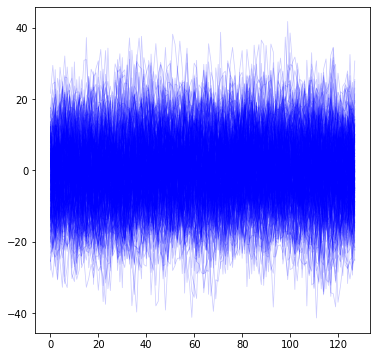

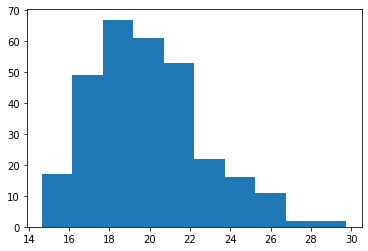

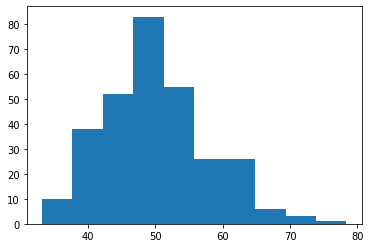

In [339]:
# note noise level depends on electrode size - target noise amplitude 50-100 
scaling_factor = 10# 15, 25
noise_generator = cn.powerlaw_psd_gaussian
p1 = 1
p2 = 128
args = [p1,p2]

# scaling_factor = 15# 15, 25
# noise_generator = laplace.rvs
# p1 = 0
# p2 = 0.88
# p3 = len(new_time) # generate noise at lower sampling rate then interpolate
# args = [p1,p2,p3]



plt.figure(figsize=(6,6))
noise_stdevs = []
noise_depths = []
print(p2,num_pts)
for i in range(300):
    noise_signal = scaling_factor*noise_generator(*args)
    
    
    plt.plot(noise_signal,color='b',alpha=0.2,linewidth=0.75)
    
    noise_stdevs.append(np.std(noise_signal))
    noise_depths.append(np.max(noise_signal)-np.min(noise_signal))

# plt.ylim([-175,125])


plt.figure()
noise_amplitudes = 2*np.array(noise_stdevs) # 1x = 68%, 2x = 95%
plt.hist(noise_amplitudes);

plt.figure()
noise_abs_amplitudes = np.array(noise_depths) # 1x = 68%, 2x = 95%
plt.hist(noise_abs_amplitudes);

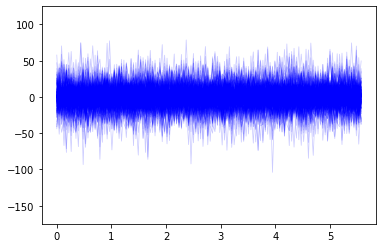

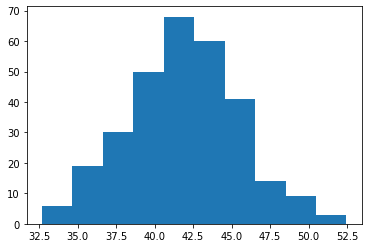

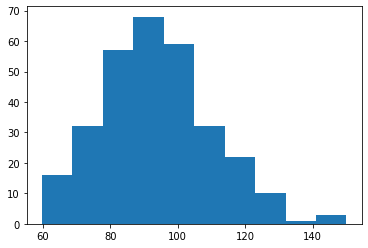

In [307]:
# note noise level depends on electrode size - target noise amplitude 50-100 
scaling_factor = 20 # 15, 25

# noise_generator = cn.powerlaw_psd_gaussian
# p1 = 1
# p2 = len(new_time)
# args = [p1,p2]

noise_generator = laplace.rvs
p1 = 0
p2 = 0.5
p3 = len(new_time)
args = [p1,p2,p3]




# noise_signal = scaling_factor*noise_generator(*args)
# print(np.min(noise_signal),np.max(noise_signal),np.max(noise_signal)-np.min(noise_signal))
# plt.figure()
# plt.plot(noise_signal)


plt.figure()
noise_stdevs = []
noise_depths = []
for i in range(300):
    noise_signal = scaling_factor*noise_generator(*args)
    plt.plot(new_time,noise_signal,color='b',alpha=0.2,linewidth=0.75)
    
    noise_stdevs.append(np.std(noise_signal))
    noise_depths.append(np.max(noise_signal)-np.min(noise_signal))

plt.ylim([-175,125])


plt.figure()
noise_amplitudes = 3*np.array(noise_stdevs) # 1x = 68%, 2x = 95%, 3x = 99%
plt.hist(noise_amplitudes);

plt.figure()
noise_abs_amplitudes = np.array(noise_depths) 
plt.hist(noise_abs_amplitudes);

In [395]:
len(probe_df)

64

In [472]:
def preprocess_model_probe_data(probe_df,max_channel_i=15,downsample=82,resample=128,conversion_factor = 1e3,num_noisy_spikes=100):
    
    preprocessed_probe_df = probe_df.copy()
    new_ves = []
    all_amps = []
    
    duration = 5.6
    peak_shift = 1.4 # duration/4
    

    
    t= probe_df.t.iloc[0]
    dt = t[1]-t[0]
    Fs = 1000./dt
    
    # approximate times for aligning waveforms    
    max_chan_ve = probe_df[probe_df['channel_num']==max_channel_i]['ve'].iloc[0]
    peak_time = t[np.argmin(max_chan_ve)]
    
    start_time = peak_time-peak_shift
    end_time = start_time+duration
    
    # approximate reduced timeseries condition
    t_cond = (t>=start_time)&(t<end_time)
    
    # find actual maximum channel
    temp_amps = []
    for _, row_df in probe_df.iterrows():
        wave = row_df['ve']
        wave = wave[t_cond]
        amp = np.max(wave)-np.min(wave)
        
        temp_amps.append(amp)
        
    # actual times for aligning waveforms
    temp_amps = np.array(temp_amps)
    max_channel_i = np.argmax(temp_amps)
    print(max_channel_i)
    
    max_chan_ve = probe_df[probe_df['channel_num']==max_channel_i]['ve'].iloc[0]
    peak_time = t[np.argmin(max_chan_ve)]
    
    # readjust after finding real max
    start_time = peak_time-peak_shift
    end_time = start_time+duration

    
    # reduced timeseries
    t_cond = (t>=start_time)&(t<end_time)
    reduced_t = t[t_cond]
    

    T = len(reduced_t)
    
    # interpolation grid
    interp_t = np.linspace(0,duration,T)
    
    
    
    # downsample and upsample grids
    down_t = np.linspace(0,duration,downsample)
    if resample is False:
        re_t = down_t
    else:
        re_t = np.linspace(0,duration,resample)
    
    
    # iterate over channels
    for _, row_df in probe_df.iterrows():
        
        # extract signal 
        ve = row_df['ve']
        reduced_ve = ve[t_cond]
        
        # scale signal
        reduced_ve = conversion_factor*reduced_ve 
        
        # downsample signal
        cs = CubicSpline(interp_t,reduced_ve,axis=0)
        new_ve = cs(down_t)
        
        # noise details
        noise_scale = 10 # 15, 25
        noise_generator = cn.powerlaw_psd_gaussian
        p1 = 1
        p2 = (num_noisy_spikes,len(new_ve))
        args = [p1,p2]

        
        
        # add "single-trial" noise
        noise_signals = scaling_factor*noise_generator(*args)
        uncorr_noise_signal = np.mean(noise_signals,axis=0)

        synth_ve = np.add(new_ve,uncorr_noise_signal)
        
        
        
        # resample signal
        if resample is False:
            new_ve = synth_ve
        else:
            cs = CubicSpline(down_t,synth_ve,axis=0)
            new_ve = cs(re_t)
            
        # center channel
        median_ve = np.median(new_ve,axis=0)
        new_ve = np.subtract(new_ve,median_ve) 
            
        amp = np.max(new_ve)-np.min(new_ve)
        
        
        new_ves.append(new_ve)
        all_amps.append(amp)
    
    preprocessed_probe_df['ve'] = new_ves
    preprocessed_probe_df['t'] = [re_t for _ in range(len(new_ves))]
    preprocessed_probe_df['amplitude'] = all_amps
    
    return preprocessed_probe_df
        

In [130]:
def preprocess_model_probe_data(probe_df,max_channel_i=25,downsample=82,resample=128,conversion_factor = 1e3,add_global_noise=True):
    
    preprocessed_probe_df = probe_df.copy()
    new_ves = []
    all_amps = []

    
    # hard coded 
#     LOC = -0.054185433498441085
#     SCALE = 0.887006184915775
    LOC = 0.0
    SCALE = 0.5

    
    t= probe_df.t.iloc[0]
    dt = t[1]-t[0]
    Fs = 1000./dt
    
    # get times for aligning waveforms
    max_chan_ve = probe_df[probe_df['channel_num']==max_channel_i]['ve'].iloc[0]
    peak_time = t[np.argmin(max_chan_ve)]
    
    duration = 2.7
    start_time = peak_time-0.6
    end_time = start_time+duration
    
    # reduced timeseries
    t_cond = (t>=start_time)&(t<end_time)
    reduced_t = t[t_cond]

    T = len(reduced_t)
    
    # interpolation grid
    interp_t = np.linspace(0,duration,T)
    
    # downsample and upsample grids
    down_t = np.linspace(0,duration,downsample)
    if resample is False:
        re_t = down_t
    else:
        re_t = np.linspace(0,duration,resample)
    
    # global probe noise
    corr_noise_signal = laplace.rvs(LOC,SCALE,size=len(down_t))
    
    # iterate over channels
    for _, row_df in probe_df.iterrows():
        
        # extract signal 
        ve = row_df['ve']
        reduced_ve = ve[t_cond]
        
        # center and scale signal
        mean_ve = np.median(reduced_ve,axis=0)
        reduced_ve = conversion_factor*np.subtract(reduced_ve,mean_ve)
        
        # downsample signal
        cs = CubicSpline(interp_t,reduced_ve,axis=0)
        new_ve = cs(down_t)
        
        
        # add channel and probe noise
        uncorr_noise_signal = laplace.rvs(LOC,SCALE,size=len(down_t))
        if add_global_noise:
            noise_signal = corr_noise_signal + uncorr_noise_signal
        else: 
            noise_signal = uncorr_noise_signal
        
        synth_ve = np.add(new_ve,noise_signal)
        
        # resample signal
        if resample is False:
            new_ve = synth_ve
        else:
            cs = CubicSpline(down_t,synth_ve,axis=0)
            new_ve = cs(re_t)
            
        amp = np.max(new_ve)-np.min(new_ve)
        
        
        new_ves.append(new_ve)
        all_amps.append(amp)
    
    preprocessed_probe_df['ve'] = new_ves
    preprocessed_probe_df['t'] = [re_t for _ in range(len(new_ves))]
    preprocessed_probe_df['amplitude'] = all_amps
    
    return preprocessed_probe_df
        
    
    
    
    

## Nearest probe example

In [473]:
probe_df = data_df[data_df.probe_num==closest_probe]

In [474]:
prep_probe_df = preprocess_model_probe_data(probe_df,resample=128,conversion_factor=1e3,num_noisy_spikes=500)

32


In [475]:
prep_probe_df.head()

,Model_ID,t,vm,ve,x_bar,y_bar,z_bar,num_spikes,did_spike,first_spkt,probe_num,channel_num,amplitude
4032,NMLCL000482,"[0.0, 0.04409448818897638, 0.08818897637795275...","[-62.32126549805659, -62.26379333623696, -62.2...","[-0.3195797281419331, 0.11692591092036655, -0....",8.454819,-318.035754,-7.104503,2,True,1008.712,63,0,2.354348
4033,NMLCL000482,"[0.0, 0.04409448818897638, 0.08818897637795275...","[-62.32126549805659, -62.26379333623696, -62.2...","[0.37647778369507384, 0.5784581917335225, 0.30...",8.454819,-308.035754,-7.104503,2,True,1008.712,63,1,2.040922
4034,NMLCL000482,"[0.0, 0.04409448818897638, 0.08818897637795275...","[-62.32126549805659, -62.26379333623696, -62.2...","[-0.23759793946749053, -1.5413642330806536, -1...",8.454819,-298.035754,-7.104503,2,True,1008.712,63,2,2.435437
4035,NMLCL000482,"[0.0, 0.04409448818897638, 0.08818897637795275...","[-62.32126549805659, -62.26379333623696, -62.2...","[0.5720636487104744, 0.9993807839753179, 0.735...",8.454819,-288.035754,-7.104503,2,True,1008.712,63,3,2.110615
4036,NMLCL000482,"[0.0, 0.04409448818897638, 0.08818897637795275...","[-62.32126549805659, -62.26379333623696, -62.2...","[0.14407159962692734, 0.45810334058644464, 0.3...",8.454819,-278.035754,-7.104503,2,True,1008.712,63,4,1.851607


In [476]:
max_channel_i

33

0.23336806400974375


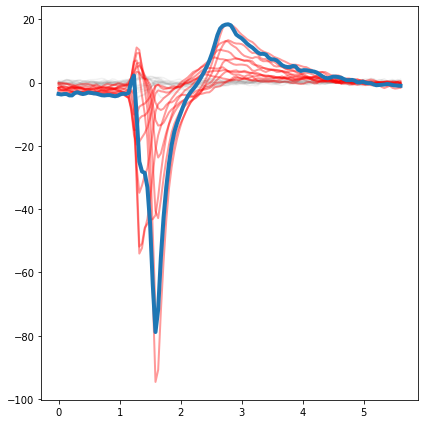

In [477]:
fig = plt.figure(figsize=(6,6))

all_amps = prep_probe_df.amplitude.values
max_amp = np.max(all_amps)
max_threshold = 0.12

medians = []
    
for _, row_df in prep_probe_df.iterrows():
    
    wave = row_df['ve']
    time = row_df['t']
    amp = np.max(wave)-np.min(wave)
    
    medians.append(np.median(wave))
    
    chan = row_df['channel_num']
    if chan==max_channel_i:
        c = 'C0'
        z = np.inf
        width = 4
        alpha = 1
        
        peak_to_trough_ratio = -1*np.max(wave)/np.min(wave)
    else:
        c = 'r'
        z = 1
        width = 2
        alpha = 0.4
        
#     norm_wave = np.divide(wave,amp)
    norm_wave = wave
    
    
    if (chan>=max_channel_i-15)&(chan<=max_channel_i+15):
    
        if amp>=10:#max_threshold*max_amp
            plt.plot(time,norm_wave,color=c,zorder=z,linewidth=width,alpha=alpha)

        else:
            plt.plot(time,norm_wave,zorder=0,alpha=0.1,color='gray')
        
#     plt.xlim([0,2.7])
#     plt.xlabel('Time (ms)',size='x-large')
#     plt.ylabel('Ve (normalized)',size='x-large')

plt.tight_layout()
print(peak_to_trough_ratio)   
# figname = 'example_sc_model.pdf'
# fig.savefig(figname,format='pdf')

In [478]:
all_channels = prep_probe_df.channel_num.values

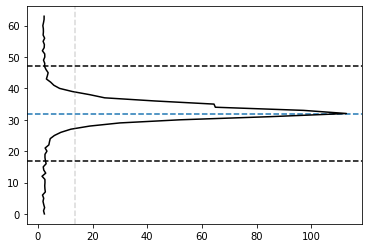

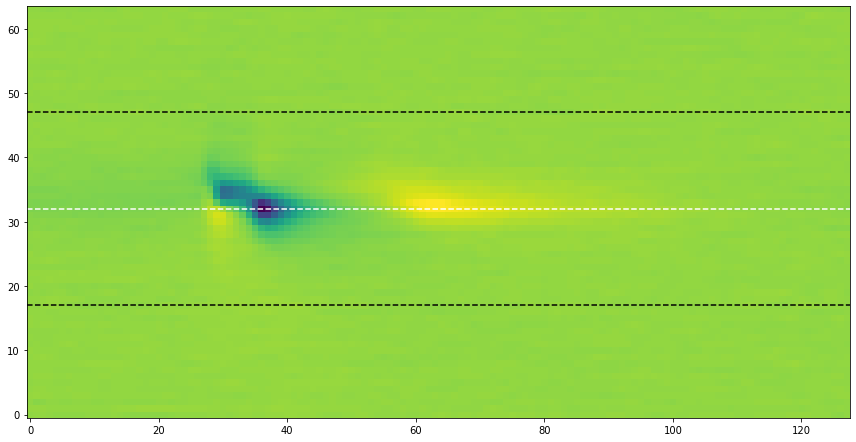

In [479]:
plt.figure()
plt.plot(all_amps,all_channels,color='k')

max_amp = np.max(all_amps)
max_channel_i = np.argmax(all_amps)
plt.axvline(0.12*max_amp,color='gray',linestyle='--',alpha=0.3) # relative to max amplitude recorded

plt.axhline(max_channel_i,linestyle='--',zorder=0)
plt.axhline(max_channel_i+15,color='k',linestyle='--')
plt.axhline(max_channel_i-15,color='k',linestyle='--')
# plt.ylim([max_channel_i-15,max_channel_i+15])


waves=[]
for _,row_df in prep_probe_df.iterrows():
    wave = list(row_df['ve'])
    
    waves.append(wave)
    

waves = np.array(waves)


fig = plt.figure(figsize=(12,8))
plt.imshow(waves)
plt.axhline(max_channel_i,color='w',linestyle='--')
plt.axhline(max_channel_i+15,color='k',linestyle='--')
plt.axhline(max_channel_i-15,color='k',linestyle='--')

# plt.yticks(range(len(prep_probe_df)),range(len(prep_probe_df)))
# plt.ylabel('Channel #',size='x-large')
# plt.xlabel('Samples (a.u.)',size='x-large')

plt.gca().invert_yaxis()

# plt.ylim([max_channel_i-15,max_channel_i+15])

# plt.colorbar(shrink=0.25,label='Ve')
plt.tight_layout()
# figname = 'example_mc_model.pdf'
# fig.savefig(figname,format='pdf');

## Farthest probe example

In [480]:
probe_df = data_df[data_df.probe_num==farthest_probe]

In [491]:
prep_probe_df = preprocess_model_probe_data(probe_df,resample=128,
                                            conversion_factor=1e3,
                                            num_noisy_spikes=1000 # this value affects the signal-to-noise ratio of the unit
                                           )

32


0.17061744648382518


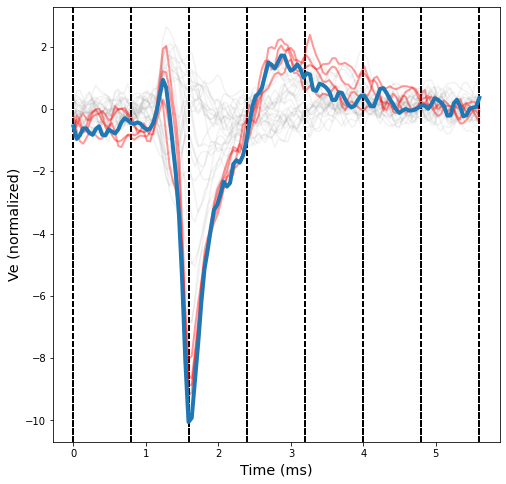

In [492]:
plt.figure(figsize=(8,8))

all_amps = prep_probe_df.amplitude.values
max_amp = np.max(all_amps)
max_channel_i = np.argmax(all_amps)
max_threshold = 0.12
peak_shift = 1.6
    
for _, row_df in prep_probe_df.iterrows():
    
    wave = row_df['ve']
    time = row_df['t']
    amp = np.max(wave)-np.min(wave)
    
    chan = row_df['channel_num']
    if chan==max_channel_i:
        c = 'C0'
        z = np.inf
        width = 4
        alpha = 1
        
        peak_to_trough_ratio = -1*np.max(wave)/np.min(wave)
    else:
        c = 'r'
        z = 1
        width = 2
        alpha = 0.4
        
#     norm_wave = np.divide(wave,amp)
    norm_wave = wave
    
    if (chan>=max_channel_i-15)&(chan<=max_channel_i+15):
    
        if amp>=10:#max_threshold*max_amp
            plt.plot(time,norm_wave,color=c,zorder=z,linewidth=width,alpha=alpha)

        else:
            plt.plot(time,norm_wave,zorder=0,alpha=0.1,color='gray')
    
    
    for i in range(8):
        plt.axvline(0.5*peak_shift*i,color='k',linestyle='--',zorder=0)
        
    plt.xlabel('Time (ms)',size='x-large')
    plt.ylabel('Ve (normalized)',size='x-large')
    
print(peak_to_trough_ratio)

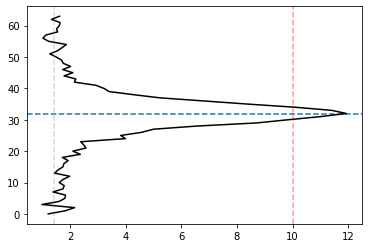

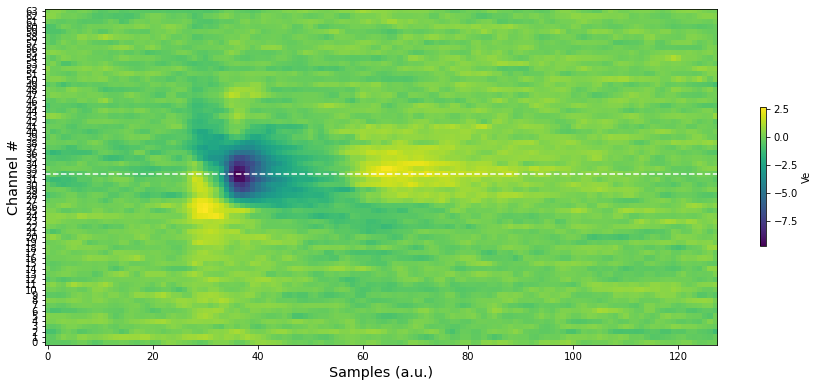

In [367]:
plt.figure()
plt.plot(all_amps,all_channels,color='k')

max_amp = np.max(all_amps)
plt.axvline(0.12*max_amp,color='gray',linestyle='--',alpha=0.3) # relative to max amplitude recorded
plt.axvline(10,color='r',linestyle='--',alpha=0.4) # theoretical limit
plt.axhline(max_channel_i,linestyle='--',zorder=0)
# plt.ylim([max_channel_i-15,max_channel_i+15])


waves=[]
for _,row_df in prep_probe_df.iterrows():
    wave = list(row_df['ve'])
    
    waves.append(wave)
    
    
waves = np.array(waves)

plt.figure(figsize=(12.5,8))
plt.imshow(waves)
plt.axhline(max_channel_i,color='w',linestyle='--')

plt.yticks(range(len(prep_probe_df)),range(len(prep_probe_df)))
plt.ylabel('Channel #',size='x-large')
plt.xlabel('Samples (a.u.)',size='x-large')

plt.gca().invert_yaxis()

# plt.ylim([max_channel_i-15,max_channel_i+15])

plt.colorbar(shrink=0.25,label='Ve')
plt.tight_layout();

## Reformat data to better match AIBS DataFrames

In [50]:
cwd = os.getcwd()
parent_dir = os.path.dirname(cwd)
workspace_dir = os.path.dirname(parent_dir)
sys.path.append(parent_dir)
sys.path.append(workspace_dir)

data_dir = 'test_data'
path_to_data_2 = os.path.join(workspace_dir,data_dir,'download_data_2')


# VISp waveforms
session_id = 751348571
f = os.path.join(path_to_data_2,'visp_waves_%s.pkl'%str(session_id))
waves_df = pd.read_pickle(f)

In [51]:
waves_df.columns.tolist()

['session_id', 'waveform', 'channel_num', 'channel', 'amplitude']

In [52]:
prep_probe_df.columns.tolist()

['Model_ID',
 't',
 'vm',
 've',
 'x_bar',
 'y_bar',
 'z_bar',
 'num_spikes',
 'did_spike',
 'first_spkt',
 'probe_num',
 'channel_num',
 'amplitude']

In [53]:
unique_probes = np.unique(probe_nums)

columns = waves_df.columns.tolist()
columns.remove('channel')
model_waves_df = pd.DataFrame(columns=columns)

for probe_id in unique_probes:
    
    probe_df = data_df[data_df.probe_num==probe_id]
    
    # preprocess data
    prep_probe_df = preprocess_model_probe_data(probe_df,
                                                resample=resample,
                                                add_global_noise=global_noise,
                                                conversion_factor=1e3)
    
    temp_df = pd.DataFrame(columns=columns)
    temp_df['session_id'] = prep_probe_df['probe_num'].tolist()
    temp_df['waveform'] = prep_probe_df['ve'].tolist()
    temp_df['channel_num'] = prep_probe_df['channel_num'].tolist()
    temp_df['amplitude'] = prep_probe_df['amplitude'].tolist()
    
    join_frames = [model_waves_df,temp_df]
    model_waves_df = pd.concat(join_frames,ignore_index=True)
    
    
    

In [54]:
model_waves_df['neuron_type'] = [cellLabel for _ in range(len(model_waves_df))]


In [55]:
model_waves_df.head()

,session_id,waveform,channel_num,amplitude,neuron_type
0,0,"[-0.16212811561967685, -0.32005677311671427, -...",0,3.931005,L6_IPC
1,0,"[-0.0563575202229162, 0.7984755231885936, -0.2...",1,3.754632,L6_IPC
2,0,"[2.4248830537362434, 0.1140084071655496, 0.287...",2,4.364904,L6_IPC
3,0,"[-0.06521294709710346, 0.14348035610467258, -0...",3,4.117140,L6_IPC
4,0,"[-0.0022168260931348972, 0.41953294270535185, ...",4,4.457664,L6_IPC


In [56]:
np.unique(model_waves_df.session_id.values)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
       53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69,
       70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86,
       87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99], dtype=object)

In [57]:
f

'/home/vrhaynes/workspace/scratchbooks/test_data/download_data_2/visp_waves_751348571.pkl'

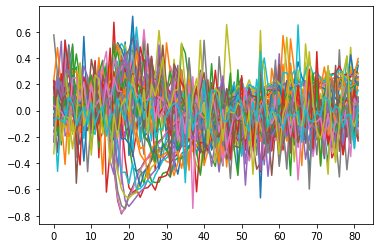

In [58]:
plot_df = model_waves_df[model_waves_df.session_id==closest_probe]

for _, row_df in plot_df.iterrows():
    
    plt.plot(np.divide(row_df['waveform'],np.max(row_df['waveform'])-np.min(row_df['waveform'])))